# Lom světla na několika rozhraních

## Rozbor úlohy

<img src="Rozbor_ulohy.jpg" alt="drawing" width="900"/>

Lineární funkce, která popisuje paprsek $p_0$
$$y = kx + q$$

$$k = tan (\beta_0)$$

$$\beta_0 = \frac{\pi}{2} - \phi_{in}$$


Průsečík $[x_0,y_0]$ paprsku (lineárni funkce) s funkcí $f_0$, která charakterizuje opticky povrch, byl řešen Newtonovou metodou. Derivací funkce $f_0$ byla určená směrnice tečny $k_t$ funkce $f_0$ v bodě $[x_0,y_0]$

$$k_t = f'(x_0)$$

$$\tau = arctan (k_t)$$ 


Z geometrie úlohy vyplývá, že pro úhel dopadu $\phi_0$ platí: 

$$\phi_0 = \frac{\pi}{2} - \tau + \beta_0$$

Ze Snellova zákona lze dopočítat úhel lomu $\phi_1$:

$$\phi_1 = arcsin(sin \phi_0 \frac{n_0}{n_1})$$

Pro určení nového předpisu funkce popisující parsek, je zapotřebí určit úhel $\beta_1$, ze kterého je určena nová směrnice

$$\beta_1 = -\frac{\pi}{2} + \phi_1 + \tau$$ 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import sympy as sp
from sympy import lambdify


x0 = sp.Symbol("x0")
x = np.linspace(0, 1, 100)

# úhel dopadu příchozího paprsku
phiin =np.pi * 0 / 180  

# indexy lomu prostředí 
n = [1, 1, 1.73, 1, 1.62, 1, 1.73, 1.62, 1, 1.62, 1, 1.62, 1]

# vstupní parsek
def p0(x, pip):
    x_p0 = pip
    y_p0 = 0
    k = np.tan(np.pi / 2 - phiin)
    q = -k * x_p0 + y_p0
    return k * x + q 

# funkce nultého (pomocného) povrchu 
def f0(x):
    return x*0


# Newtonova metoda pro výpočet průsečíků paprsku s optickým povrchem
def newton(paprsek, funkce, nk=3):
    '''Paprsek - lineární funkce popisující paprsek 
       funkce - funkce popisující optický povrch na který dopadá paprsek
       nk - počet provedených iterací'''
    
    # výpočet počáteční hodnoty xi
    lf = (1 - x0) * funkce(x0).subs(x0, 0) + x0 * funkce(x0).subs(x0, 1)
    xi = sp.solve(paprsek - lf, x0)
    xi = xi[0]
    
    for i in range(nk):
        dfx = sp.diff(funkce(x0), x0) # derivace funkce optického povrchu
        dp1 = sp.diff(paprsek, x0)    # derivace paprsku
        x1 = xi - (funkce(x0).subs(x0, xi) - paprsek.subs(x0, xi)) / (dfx.subs(x0, xi) - dp1.subs(x0, xi))
        xi = x1.evalf()
    xi = xi
    y = funkce(x0).subs(x0, xi)
    
    # výpočet směrnice tečny funkce optického povrchu v bodě [xi, y]
    dfx = sp.diff(funkce(x0), x0)
    taut = sp.atan(dfx).subs(x0, xi).evalf()
    return xi, y, taut

# Trasování paprsku
def paprsek(pip, funkce):
    '''Pip - posun paprsku v ose x  
       funkce - funkce popisující optický povrch na který dopadá paprsek'''
    zlom = 1    # kladná směrnice paprsku (při průchodu optickou osou -> -1)
    phip = []   # úhel lomu paprsku
    tau = []    # úhel směrnice tečny funkce
    beta = []   # úhel směrnice paprsku
    prus = []   # průsečíky paprsku a funkcí optických povrchů

    phip.append(phiin)
    beta.append(np.pi / 2 - phiin)
    
    # výpočet průsečíku pro nulový povrch
    xa_0, ya_0, taut_0 = newton(p0(x0, pip), f0)
    prus.append((xa_0, ya_0))
    tau.append(taut_0)

    for j in range(len(funkce)):
        # výpočet úhlu lomu ze Snellova zákona
        phia = sp.asin(sp.sin(np.pi/2 - tau[-1] + beta[-1]) * n[j] / n[j + 1])
        phip.append(phia)

        # lineární funkce definující paprsek
        if zlom == -1:
            beta1 = -np.pi/2 + phip[-1] + tau[-1]
            k = zlom * sp.tan(beta1)
            beta.append(beta1)
            q = prus[-1][1] - k * prus[-1][0]
            p = k * x0 + q
        else:
            beta1 = -np.pi/2 + phip[-1] + tau[-1]
            k = zlom * sp.tan(beta1)
            beta.append(beta1)
            q = prus[-1][1] - k * prus[-1][0]
            p = k * x0 + q

        # bod ve kterém by paprsek proťal optickou osu se uloží
        # paprsek se v tomto bodě odrazí symetricky zpět
        if k < 0 and q < funkce[j](0):
            prus.append((0, q))
            zlom = -1
            k = zlom * k
            p = k * x0 + q
            
        # bod ve kterém paprsek protne okraj optické soustavy se uloží a paprsek se dále netrasuje
        if k > 0 and k + q < funkce[j](1):
            prus.append((1, k + q))
            break

        # výpočet průsečíku parsku s optickým povrchem
        xa, ya, taut = newton(p, funkce[j])
        prus.append((xa, ya))
        tau.append(taut)
    return prus

# vytvoření listů průsečíků
def list_pruseciku(paprsek):
    prux = []
    prux2 = []
    pruy = []
    for i in range(len(paprsek)):
        px = paprsek[i][0]
        px2 = -1 * paprsek[i][0]
        py = paprsek[i][1]
        prux.append(px)
        prux2.append(px2)
        pruy.append(py)
    return prux, prux2, pruy


# funkce pro vykreslení jednotlivých paprsků pomocí barevné mapy
def trasovani_pap(posun, funkce):
    numc = len(posun)
    colors = pl.cm.Reds(np.linspace(0, 1, numc))
    for i in range(len(posun)):
        r = paprsek(posun[i], funkce)
        pr = list_pruseciku(r)
        plt.plot(pr[0], pr[2], transform=tr, color=colors[i])
        plt.plot(pr[1], pr[2], transform=tr, color=colors[i])




## Ověření fungování trasovacího algoritmu
Pomocí čočky o známých poloměrech křivosti $R_1$ a $R_2$ tloušťkou $d$ a indexu lomu $n$, lze vypočítat ohnisko $f$ a sečnou vzdálenost $S_f$

$$ f = \frac{ n \cdot R_1 \cdot R_2}{n \cdot (n - 1) \cdot (R_2 - R_1) + (n - 1)^2 \cdot d}$$

$$ S_f = f \cdot \left[1 - \frac{d \cdot (n - 1)}{n \cdot R_1}\right]$$


Sečná vzdálenost:  8.157083812812 




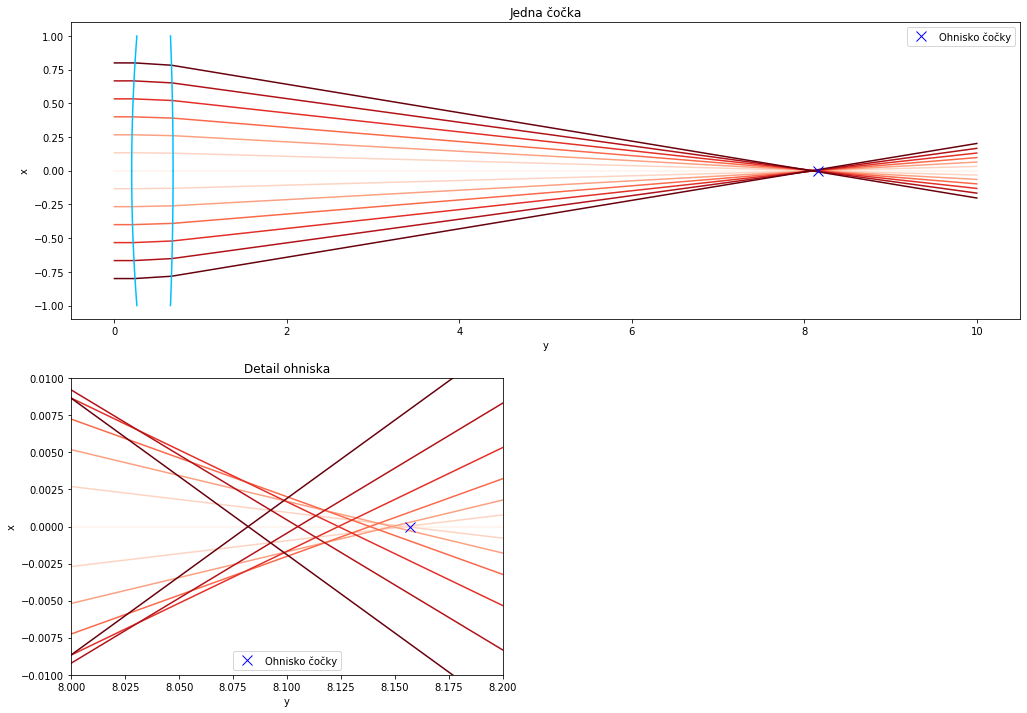

In [2]:
# funkce pro výpočet ohniska a sečné vzdálenosti čočky
def cocka(r1, r2, d, n):
    f = (n*r1*r2)/(n*(n-1)*(r2-r1)+((n-1)**2)*d)
    sf = f*(1-(d*(n-1))/(n*r1))
    return sf

# sečná vzdálenost konkrétní čočky
sf = cocka(8.33, -16.62, 0.48, 1.73) + 0.68
print("\nSečná vzdálenost: ", sf, "\n\n")

# funkce popisující optické povrchy čočky
def f1(x):
    y_f = 8.33 + 0.2
    r = 8.33
    return -sp.sqrt(r ** 2 - x ** 2) + y_f


def f2(x):
    y_f = -16.62 + 0.68
    r = 16.62
    return sp.sqrt(r ** 2 - x ** 2) + y_f

def fend(x):
    return x*0 + 10


# list funkcí popisujících optické povrchy čočky
fce1 = [f1, f2, fend]

# pole paprsků
pole = np.linspace(0, 0.8, 7)


# vykreslení průchodu paprsku čočkou
#---------------------------------------

# převod funkcí definovaných pomocí sympy na numpy (pro vykreslení pomocí matplotlib.pyplot)
def fy(fce):
    return lambdify(x0, fce(x0), modules=['numpy'])(x)


fig = plt.figure(1, figsize=(17,12))
ax = fig.add_subplot(211)

# transformace pro horizontální zobrazení
base_trans = ax.transData
tr = mpl.transforms.Affine2D().rotate_deg(-90) + base_trans

# vypočet průsečíků a vykreslení paprsků
trasovani_pap(pole, fce1)

# vykreslení optických povrchů čočky
ax.plot(x, fy(f1), "deepskyblue", -1*x, fy(f1), "deepskyblue", transform=tr)
ax.plot(x, fy(f2), "deepskyblue", -1*x, fy(f2), "deepskyblue", transform=tr)

# označení teoretického ohniska čočky
ax.plot(0, sf, "bx", markersize=10, label="Ohnisko čočky", transform=tr)

ax.set_xlabel("y")
ax.set_ylabel("x")
ax.set_title("Jedna čočka")
ax.legend()

# zobrazení detailu ohniska
ax2 = fig.add_subplot(223)
base_trans = ax2.transData
tr = mpl.transforms.Affine2D().rotate_deg(-90) + base_trans
trasovani_pap(pole, fce1)

ax2.plot(0, sf, "bx", markersize=10, label="Ohnisko čočky", transform=tr)
ax2.set_xlim([8, 8.20])
ax2.set_ylim ([-0.01, 0.01])
ax2.set_xlabel("y")
ax2.set_ylabel("x")
ax2.set_title("Detail ohniska")
ax2.legend()
plt.show()


## Soustava čoček
<img src="soustava_cocek.jpg" alt="drawing" width="500"/>

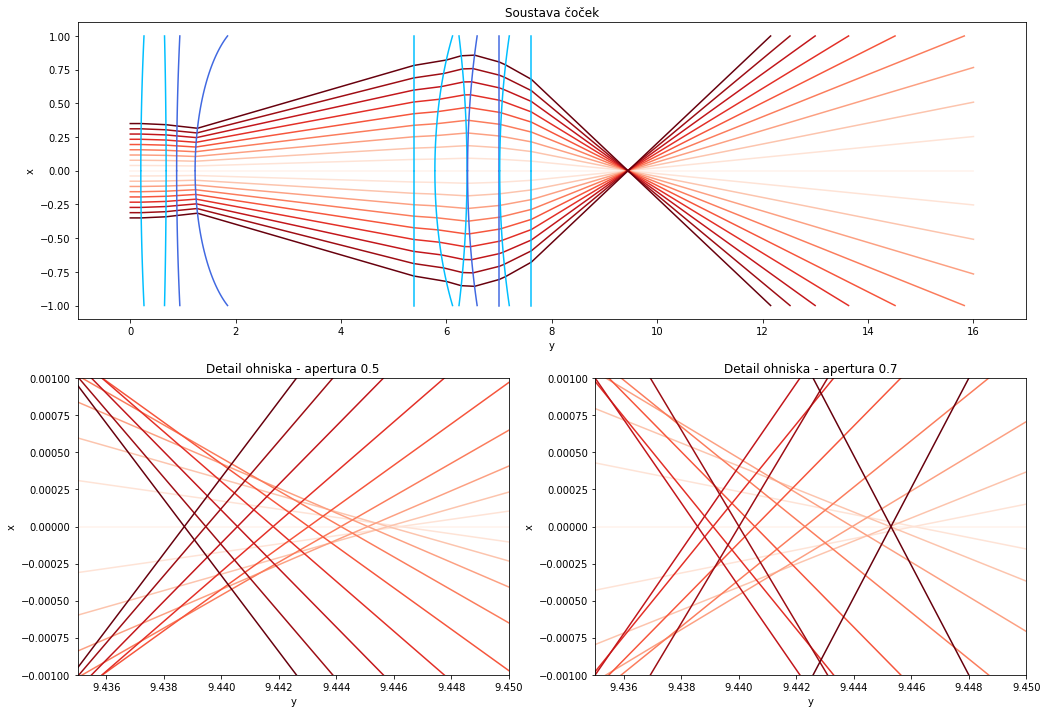

In [3]:
# funkce popisující optické povrchy dalších čoček
def f3(x):
    y_f = 8.33 + 0.68 + 0.2
    r = 8.33
    return -sp.sqrt(r ** 2 - x ** 2) + y_f


def f4(x):
    y_f = 1.12 + 1.23
    r = 1.12
    return -sp.sqrt(r ** 2 - x ** 2) + y_f


def f5(x):
    return x*0 + 5.38


def f6(x):
    y_f = 1.66 + 5.78
    r = 1.66
    return -sp.sqrt(r ** 2 - x ** 2) + y_f


def f7(x):
    y_f = -3.36 + 6.39
    r = 3.36
    return sp.sqrt(r ** 2 - x ** 2) + y_f


def f8(x):
    y_f = 2.84 + 6.4
    r = 2.84
    return -sp.sqrt(r ** 2 - x ** 2) + y_f


def f9(x):
    return x*0 + 7


def f10(x):
    y_f = 2.84 + 7.01
    r = 2.84
    return -sp.sqrt(r ** 2 - x ** 2) + y_f


def f11(x):
    return x*0 + 7.61


def fend(x):
    return x*0 + 16

# list funkcí popisujících optické povrchy soustavy čoček
fce2 = [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, fend]

# pole paprsků
pole2 = np.linspace(0, 0.35, 10)

# vykreslení průchodu paprsku soustavou čoček
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(211)

# transformace pro horizontální zobrazení
base_trans = ax.transData
tr = mpl.transforms.Affine2D().rotate_deg(-90) + base_trans

# vypočet průsečíků a vykreslení paprsků
trasovani_pap(pole2, fce2)

#vykreslení optických porvchů čoček
plt.plot(x, fy(f1), "deepskyblue", -1*x, fy(f1), "deepskyblue", transform=tr)
plt.plot(x, fy(f2), "deepskyblue", -1*x, fy(f2), "deepskyblue", transform=tr)
plt.plot(x, fy(f3), "royalblue", -1*x, fy(f3), "royalblue", transform=tr)
plt.plot(x, fy(f4), "royalblue", -1*x, fy(f4), "royalblue", transform=tr)
plt.plot(x, f5(x), "deepskyblue", -1*x, f5(x), "deepskyblue", transform=tr)
plt.plot(x, fy(f6), "deepskyblue", -1*x, fy(f6), "deepskyblue", transform=tr)
plt.plot(x, fy(f7), "deepskyblue", -1*x, fy(f7), "deepskyblue", transform=tr)
plt.plot(x, fy(f8), "royalblue", -1*x, fy(f8), "royalblue", transform=tr)
plt.plot(x, f9(x), "royalblue", -1*x, f9(x), "royalblue", transform=tr)
plt.plot(x, fy(f10), "deepskyblue", -1*x, fy(f10), "deepskyblue", transform=tr)
plt.plot(x, f11(x), "deepskyblue", -1*x, f11(x), "deepskyblue", transform=tr)

plt.xlabel("y")
plt.ylabel("x")
plt.xlim(-1, 17)
plt.title("Soustava čoček")


# zobrazení detailu ohniska
ax2 = fig.add_subplot(224)
base_trans = ax2.transData
tr = mpl.transforms.Affine2D().rotate_deg(-90) + base_trans

trasovani_pap(pole2, fce2)

ax2.set_xlim([9.435, 9.45])
ax2.set_ylim ([-0.001, 0.001])
ax2.set_xlabel("y")
ax2.set_ylabel("x")
ax2.set_title("Detail ohniska - apertura 0.7")

ax3 = fig.add_subplot(223)
base_trans = ax3.transData
tr = mpl.transforms.Affine2D().rotate_deg(-90) + base_trans

pole3 = np.linspace(0, 0.25, 10)
trasovani_pap(pole3, fce2)

ax3.set_xlim([9.435, 9.45])
ax3.set_ylim ([-0.001, 0.001])
ax3.set_xlabel("y")
ax3.set_ylabel("x")
ax3.set_title("Detail ohniska - apertura 0.5")


plt.show()
